ADF Statistic: -1.2345585409559667, P-value: 0.6585556935828077
Data is non-stationary. Differencing will be applied.


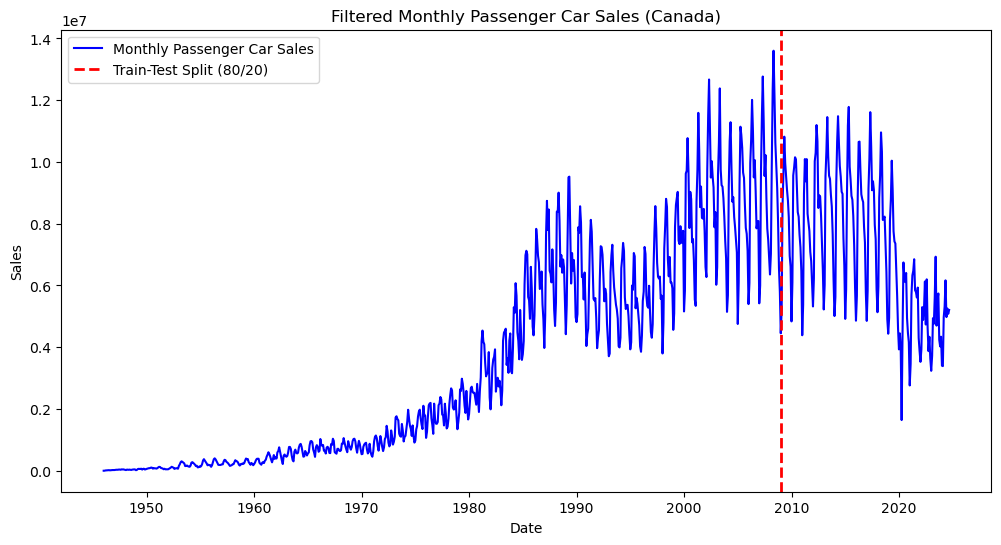

Best SARIMA params: (1, 1, 2, 0, 1, 1, 12) with AIC: 20692.14858753808
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36881D+01    |proj g|=  1.12196D-01


 This problem is unconstrained.



At iterate    5    f=  1.36803D+01    |proj g|=  3.03773D-02

At iterate   10    f=  1.36787D+01    |proj g|=  5.53386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   5.181D-06   1.368D+01
  F =   13.678669700752698     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

Seasonal Naive Model Evaluation:
MAE: 2939275.62, MSE: 14115213485927.37, RMSE: 3757021.89

SARIMA Model Evaluation:
MAE: 1439148.58, MSE: 2924281670120.21, RMSE: 1710053.12

Results saved to 'optimized_seasonal_naive_results.csv' and 'optimized_sarima_results.csv'.


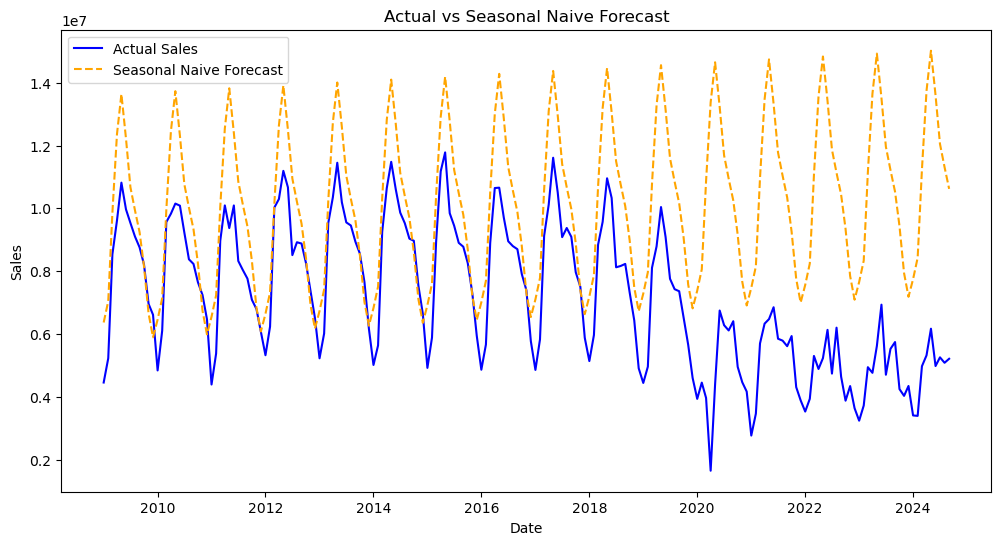

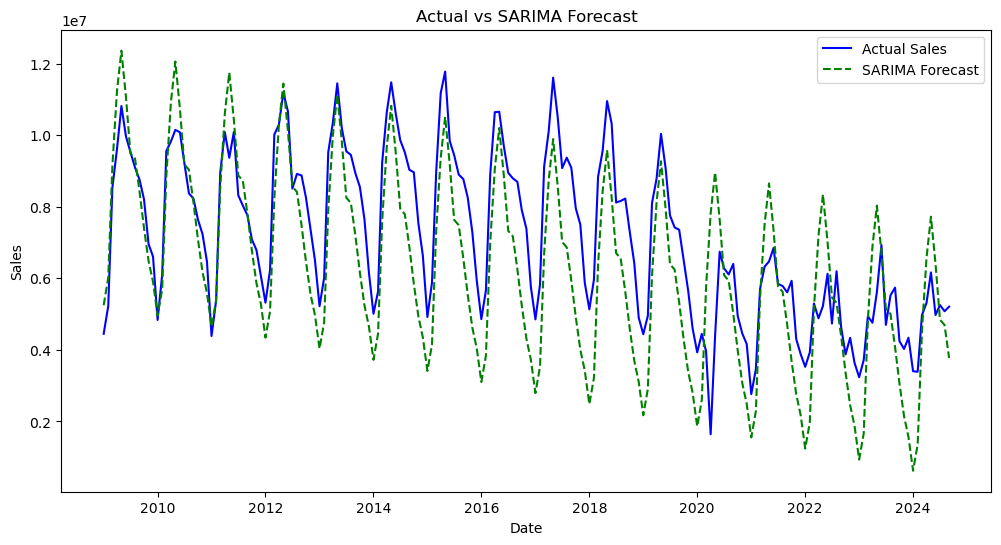

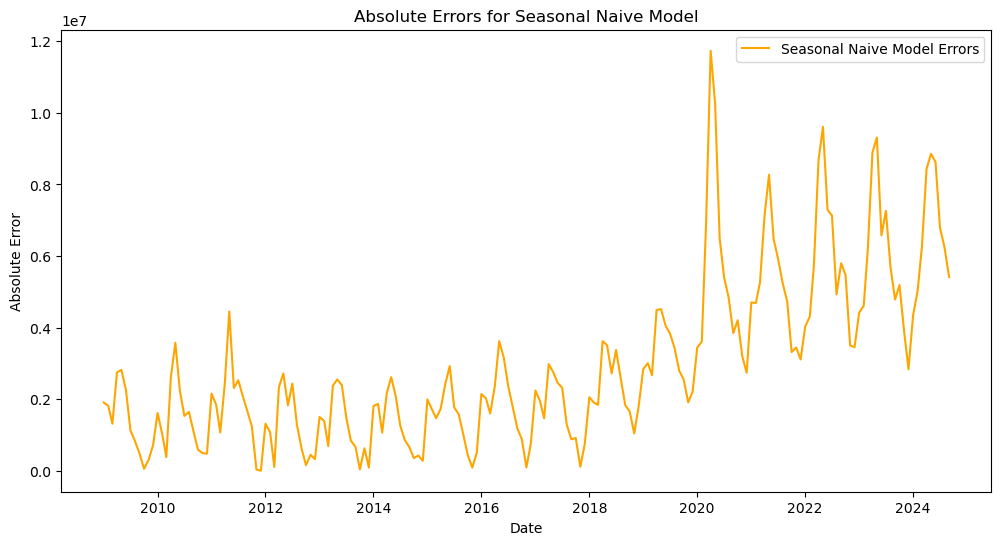

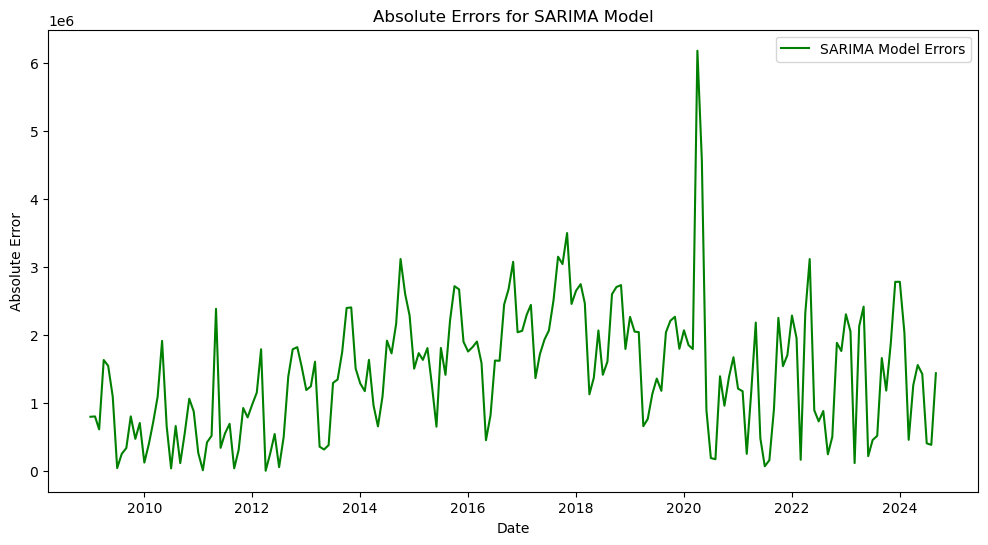


Evaluation metrics saved to 'optimized_evaluation_metrics.csv'.


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

# Step 1: Load the dataset
data = pd.read_csv('./Dataset/forecasting.csv', low_memory=False)

# Step 2: Filter for passenger car sales and unadjusted data
filtered_data = data[(data['Vehicle type'] == 'Passenger cars') & 
                     (data['Seasonal adjustment'] == 'Unadjusted')]

# Select only relevant columns: REF_DATE and VALUE
filtered_data = filtered_data[['REF_DATE', 'VALUE']]

# Rename columns for easier handling
filtered_data.rename(columns={'REF_DATE': 'Date', 'VALUE': 'Sales'}, inplace=True)

# Convert 'Date' to datetime format
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'], format='%Y-%m')

# Handle duplicate dates by aggregating sales
filtered_data = filtered_data.groupby('Date')['Sales'].sum().reset_index()

# Set the aggregated 'Date' as the index and set frequency
filtered_data.set_index('Date', inplace=True)
filtered_data = filtered_data.asfreq('MS')  # Monthly Start frequency

# Handle missing values using forward fill
# missing_percentage = filtered_data['Sales'].isna().sum() / len(filtered_data) * 100
# print(f"Percentage of missing values: {missing_percentage:.2f}%")
filtered_data['Sales'] = filtered_data['Sales'].ffill()



# Check stationarity with ADF test
result = adfuller(filtered_data['Sales'])
print(f"ADF Statistic: {result[0]}, P-value: {result[1]}")
if result[1] > 0.05:
    print("Data is non-stationary. Differencing will be applied.")
    filtered_data['Sales_diff'] = filtered_data['Sales'].diff().dropna()
else:
    filtered_data['Sales_diff'] = filtered_data['Sales']

# Step 3: Plot the filtered dataset with vertical lines for 80/20 split
split_index = int(len(filtered_data) * 0.8)
split_date = filtered_data.index[split_index]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Sales'], label='Monthly Passenger Car Sales', color='blue')
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Train-Test Split (80/20)')
plt.title('Filtered Monthly Passenger Car Sales (Canada)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 4: Split data into 80% training and 20% testing
train_data = filtered_data.iloc[:split_index]
test_data = filtered_data.iloc[split_index:]

# Step 5: Optimize SARIMA parameters using grid search
p = d = q = range(0, 3)  # ARIMA params
P = D = Q = range(0, 2)  # Seasonal params
m = 12  # Monthly seasonality

param_combinations = list(itertools.product(p, d, q, P, D, Q, [m]))
best_score, best_params = float("inf"), None

for param in param_combinations:
    try:
        model = SARIMAX(train_data['Sales'], 
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_score:
            best_score, best_params = results.aic, param
    except:
        continue

print(f"Best SARIMA params: {best_params} with AIC: {best_score}")

# Fit SARIMA Model with optimized parameters
sarima_model = SARIMAX(train_data['Sales'], 
                       order=(best_params[0], best_params[1], best_params[2]),
                       seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Forecast on Testing Data using SARIMA
sarima_forecast = sarima_result.predict(start=test_data.index[0], end=test_data.index[-1])

# Step 6: Optimize Seasonal Naive Baseline
# Seasonal Naive with trend adjustment
seasonal_period = 12  # Monthly data, 12 months in a year
test_data = test_data.copy()

# Compute seasonal pattern and trend
seasonal_pattern = train_data['Sales'].iloc[-seasonal_period:].values.tolist()
trend = (train_data['Sales'].iloc[-1] - train_data['Sales'].iloc[0]) / len(train_data)  # Linear trend
repeats_needed = (len(test_data) // seasonal_period) + 1

# Adjust seasonal naive with trend
seasonal_naive_forecast = []
for i in range(len(test_data)):
    seasonal_index = i % seasonal_period
    adjusted_value = seasonal_pattern[seasonal_index] + trend * (i + 1)
    seasonal_naive_forecast.append(adjusted_value)

# Assign the optimized seasonal naive forecast to the test data
test_data['Seasonal_Naive_Forecast'] = seasonal_naive_forecast[:len(test_data)]

# Step 7: Evaluate Seasonal Naive and SARIMA Models
# Seasonal Naive evaluation
naive_actual = test_data['Sales']
naive_pred = test_data['Seasonal_Naive_Forecast']

naive_mae = mean_absolute_error(naive_actual, naive_pred)
naive_mse = mean_squared_error(naive_actual, naive_pred)
naive_rmse = np.sqrt(naive_mse)

# SARIMA evaluation
sarima_actual = test_data['Sales']
sarima_mae = mean_absolute_error(sarima_actual, sarima_forecast)
sarima_mse = mean_squared_error(sarima_actual, sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)

# Print Evaluation Results
print("\nSeasonal Naive Model Evaluation:")
print(f"MAE: {naive_mae:.2f}, MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

print("\nSARIMA Model Evaluation:")
print(f"MAE: {sarima_mae:.2f}, MSE: {sarima_mse:.2f}, RMSE: {sarima_rmse:.2f}")

# Step 8: Save Actual and Predicted Results for Both Models
naive_comparison = pd.DataFrame({
    'Date': test_data.index,
    'Actual': naive_actual.values,
    'Optimized_Seasonal_Naive_Forecast': naive_pred.values
})
naive_comparison.to_csv('optimized_seasonal_naive_results.csv', index=False)

sarima_comparison = pd.DataFrame({
    'Date': test_data.index,
    'Actual': sarima_actual.values,
    'Optimized_SARIMA_Forecast': sarima_forecast.values
})
sarima_comparison.to_csv('optimized_sarima_results.csv', index=False)

print("\nResults saved to 'optimized_seasonal_naive_results.csv' and 'optimized_sarima_results.csv'.")

# Step 9: Plot Actual vs Forecasts Separately
# Plot Actual vs Optimized Seasonal Naive Forecast
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, naive_actual, label='Actual Sales', color='blue')
plt.plot(test_data.index, naive_pred, label='Seasonal Naive Forecast', linestyle='--', color='orange')
plt.title('Actual vs Seasonal Naive Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot Actual vs Optimized SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, sarima_actual, label='Actual Sales', color='blue')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='green')
plt.title('Actual vs SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 10: Plot Absolute Errors Separately
# Plot Absolute Errors for Optimized Seasonal Naive Model
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.abs(naive_actual - naive_pred), label='Seasonal Naive Model Errors', color='orange')
plt.title('Absolute Errors for Seasonal Naive Model')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

# Plot Absolute Errors for Optimized SARIMA Model
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.abs(sarima_actual - sarima_forecast), label='SARIMA Model Errors', color='green')
plt.title('Absolute Errors for SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

# Step 11: Save Evaluation Metrics
evaluation_metrics = pd.DataFrame({
    'Model': ['Seasonal Naive', 'SARIMA'],
    'MAE': [naive_mae, sarima_mae],
    'MSE': [naive_mse, sarima_mse],
    'RMSE': [naive_rmse, sarima_rmse]
})
evaluation_metrics.to_csv('optimized_evaluation_metrics.csv', index=False)

print("\nEvaluation metrics saved to 'optimized_evaluation_metrics.csv'.")
